Librairies

In [1]:
#importer les librairies necessaires
from pandas_datareader import data as web
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import yahoo_fin.stock_info as yfn
import scipy.stats as SS
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import financedatabase as fd
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.cla import CLA
import fredapi
import pyfolio as pf
from scipy.stats import norm, anderson
from scipy.stats import skewnorm, skewtest
from pypfopt import risk_models
from pypfopt import expected_returns
import os
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import math
from pandas.plotting import table

ModuleNotFoundError: No module named 'yahoo_fin'

In [ ]:
# Définir le chemin complet pour l'enregistrement
enregistrement_graphiques = r'C:\Users\Mon Port\OneDrive\Documents\COURS M2\S1\UE1\Modélisation Financière\Graphiques rapport'
pdf_filename = 'C:\\Users\\Mon Port\\OneDrive\\Documents\\rapport.pdf'

Fonctions

Creation Dataframe

In [ ]:
def Calcul_Rendement (dataframe) :
    rendement = dataframe.pct_change()
    rendement = rendement.dropna()
    return rendement

def Calcul_Valeur_PF (prix_actifs, poids) :
    valeur = np.dot(prix_actifs.values, poids)
    valeur = pd.DataFrame(valeur, columns=['Portefeuille'], index=prix_actifs.index)
    return valeur

def Creation_DF_Base100 (PF_prices, PF_returns, Indices_returns) :
    # Créer un DataFrame vide avec une colonne 'Portfolio_Value'
    Base_100 = pd.DataFrame(index=PF_prices.index, columns=['Portefeuille','Indice'])

    # Initialiser la valeur du portefeuille à 100
    Base_100['Portefeuille'][0] = 100
    Base_100['Indice'][0] = 100

    # Calculer la valeur du portefeuille au fil du temps
    for i in range(1, len(PF_prices)-1):
        Base_100['Portefeuille'][i] = Base_100['Portefeuille'][i-1] * (1 + PF_returns.iloc[i,0])
        Base_100['Indice'][i] = Base_100['Indice'][i-1] * (1 + Indices_returns.iloc[i,0])


    # Afficher le DataFrame résultant
    print(Base_100)
    return Base_100

Creation et enregistrements graphiques

In [ ]:
def Processus_Creation_Sauvegarde_Graphique_2df (df1, label_df1, df2, label_df2, titre_graphique, chemin_complet) :
    # Plot portfolio returns
    df1.plot().set_ylabel(label_df1)
    sns.lineplot(x=df2.index, y=df2.iloc[:,0], data=df2, label = label_df2)
    plt.title(titre_graphique)
    # Enregistrer le graphique en tant qu'image (par exemple, en format PNG)
    Save = os.path.join(chemin_complet, titre_graphique + '.png')
    plt.savefig(Save)
    plt.show()
    return Save

def Processus_Creation_Sauvegarde_Graphique_1df (df1, titre_graphique, chemin_complet) :
    df1.plot()
    plt.title(titre_graphique)
    # Enregistrer le graphique en tant qu'image (par exemple, en format PNG)
    Save = os.path.join(chemin_complet, titre_graphique + '.png')
    plt.savefig(Save)
    plt.show()
    return Save

def Creation_Graphique_VaR_CVaR_95 (df_returns, VaR95, CVaR95, titre_graphique, chemin_complet) :
    # Création d'un histogramme des rendements
    plt.hist(df_returns, bins=30, density=True, alpha=0.7, color='blue', label='Rendements')

    plt.axvline(x = VaR95, c='r', label = "VaR, 95% confidence level")
    plt.axvline(x = CVaR95, c='g', label = "CVaR, worst 5% of outcomes")
    plt.title(titre_graphique)
    plt.legend()
    # Enregistrer le graphique en tant qu'image (par exemple, en format PNG)
    Save = os.path.join(chemin_complet, titre_graphique + '.png')
    plt.savefig(Save)
    plt.show()
    return  Save

Fonctions de calcul

In [ ]:
def Calcul_mean (df) :
    mean = df.mean()
    mean = float(mean)
    print (round(100 * mean, 7), '%')
    return mean

def Calcul_Std_PF (returnPF, W) :
    covariance = returnPF.cov()*252
    PFvariance = np.dot(W.T, np.dot(covariance, W))
    PFvariance = float(PFvariance)
    PFstd = math.sqrt(PFvariance)
    print(PFstd)
    return PFstd

def Calcul_CAGR (dataframe) :
    CAGR = mean_historical_return(dataframe, frequency = 252)
    CAGR = float(CAGR)
    print(round(100 * CAGR, 15), '%')
    return CAGR

def Calcul_Sharpe_Ratio (PF_prices_CAGR, rfr, PF_returns_variance) :
    sharpe_ratio = ((PF_prices_CAGR - rfr) /PF_returns_variance)
    sharpe_ratio = float(sharpe_ratio)
    print (sharpe_ratio)
    return sharpe_ratio

def Calcul_Sortino_Ratio (df_Return, rfr) :
    # Create a downside return series with the negative returns only
    downside_returns = df_Return.iloc[:,0].loc[df_Return.iloc[:,0] < 0]

    # Calculate expected return and std dev of downside
    expected_return = df_Return.iloc[:,0].mean()
    down_stdev = downside_returns.std()

    # Calculate the sortino ratio
    sortino_ratio = (expected_return - rfr)/down_stdev

    sortino_ratio = float(sortino_ratio)
    # Print the results
    print("Expected return  : ", expected_return*100, '%')
    print("Downside risk  : ", down_stdev*100, '%')
    print("Sortino ratio : ", sortino_ratio)
    return sortino_ratio

def Calcul_DrawDown (df_prices, titre_graphique) :
    # Calculate the max value
    roll_max = df_prices.rolling(center=False,min_periods=1,window=252).max()

    # Calculate the daily draw-down relative to the max
    daily_drawdown = df_prices/roll_max - 1.0

    # Calculate the minimum (negative) daily draw-down
    max_daily_draw_down = daily_drawdown.rolling(center=False,min_periods=1,window=252).min()

    # Valeur minimum daily draw-down
    max_daily_drawdown = max_daily_draw_down.iloc[-1, 0]

    max_daily_drawdown = float(max_daily_drawdown)

    print(max_daily_drawdown)

    Save = Processus_Creation_Sauvegarde_Graphique_2df (daily_drawdown, 'Rendement', max_daily_draw_down, 'max_daily_drawdown', titre_graphique, enregistrement_graphiques)
    return max_daily_drawdown, Save

def Calcul_VaR_95 (df_returns) :
    VaR95 = df_returns.quantile(0.05)
    VaR95 = float(VaR95)
    print('VaR 95 :', VaR95)
    return VaR95

def Calcul_CVaR_95 (df_returns, VaR95) :
    CVaR95 = df_returns[df_returns <= VaR95].mean()
    CVaR95 = float(CVaR95)
    print('CVaR 95 :', CVaR95)
    return CVaR95



In [ ]:
pdf_filename
c = canvas.Canvas(pdf_filename, pagesize=letter)

def nouvelle_page_PDF_2_graphiques (graph1, graph2) :
    c.showPage()
    c.drawInlineImage(graph1, 72, 400, width=400, height=300)
    c.drawInlineImage(graph2, 72, 100, width=400, height=300)

def nouvelle_page_PDF_1_graphique (graph1) :
    c.showPage()
    c.drawInlineImage(graph1, 72, 400, width=400, height=300)

In [ ]:
# Initialize the Equities base
equities = fd.Equities()

In [ ]:
# IMPORTER LES TICKER ET CHARGER LES PRIX SUR 10 ANS
assets = ['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DOW', 'DPZ', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXCM', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EG', 'EIX', 'EL', 'ELV', 'EMN', 'EMR', 'ENPH', 'EOG', 'EPAM', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'ETSY', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FCX', 'FDS', 'FDX', 'FE', 'FFIV', 'FI', 'FICO', 'FIS', 'FITB', 'FLT', 'FMC', 'FOX', 'FOXA', 'FRT', 'FSLR', 'FTNT', 'FTV', 'GD', 'GE', 'GEHC', 'GEN', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HCA', 'HD', 'HES', 'HIG', 'HII', 'HLT', 'HOLX', 'HON', 'HPE', 'HPQ', 'HRL', 'HSIC', 'HST', 'HSY', 'HUBB', 'HUM', 'HWM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INTC', 'INTU', 'INVH', 'IP', 'IPG', 'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JBL', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'K', 'KDP', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KR', 'KVUE', 'L', 'LDOS', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNT', 'LOW', 'LRCX', 'LULU', 'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'META', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOH', 'MOS', 'MPC', 'MPWR', 'MRK', 'MRNA', 'MRO', 'MS', 'MSCI', 'MSFT', 'MSI', 'MTB', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ', 'NDSN', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NOC', 'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR', 'NWS', 'NWSA', 'NXPI', 'O', 'ODFL', 'OKE', 'OMC', 'ON', 'ORCL', 'ORLY', 'OTIS', 'OXY', 'PANW', 'PARA', 'PAYC', 'PAYX', 'PCAR', 'PCG', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PODD', 'POOL', 'PPG', 'PPL', 'PRU', 'PSA', 'PSX', 'PTC', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'REG', 'REGN', 'RF', 'RHI', 'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTX', 'RVTY', 'SBAC', 'SBUX', 'SCHW', 'SHW', 'SJM', 'SLB', 'SNA', 'SNPS', 'SO', 'SPG', 'SPGI', 'SRE', 'STE', 'STLD', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG', 'TDY', 'TECH', 'TEL', 'TER', 'TFC', 'TFX', 'TGT', 'TJX', 'TMO', 'TMUS', 'TPR', 'TRGP', 'TRMB', 'TROW', 'TRV', 'TSCO', 'TSLA', 'TSN', 'TT', 'TTWO', 'TXN', 'TXT', 'TYL', 'UAL', 'UBER', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNP', 'UPS', 'URI', 'USB', 'V', 'VFC', 'VICI', 'VLO', 'VLTO', 'VMC', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VTRS', 'VZ', 'WAB', 'WAT', 'WBA', 'WBD', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WM', 'WMB', 'WMT', 'WRB', 'WRK', 'WST', 'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS']
print(assets)

['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 

In [ ]:
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)
asset_prices = yf.download(assets, start_date, end_date)['Adj Close']

[*********************100%%**********************]  503 of 503 completed


In [ ]:
# calculer l'expected return et la covariance annualisé des rendements
mu = expected_returns.mean_historical_return(asset_prices)
S = risk_models.sample_cov(asset_prices)

# optimiser en maximisant le Sharpe Ratio
ef = EfficientFrontier(mu,S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Supprimer les clés associées à des valeurs égales à zéro
optimize_weights = {cle: valeur for cle, valeur in cleaned_weights.items() if valeur != 0}

# Afficher le DATAFRAME
df_optimize = pd.DataFrame(list(optimize_weights.items()), columns=["Actions", "Poids"])
print(df_optimize)

c:\Users\Mon Port\AppData\Local\Programs\Python\Python311\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\Mon Port\AppData\Local\Programs\Python\Python311\Lib\site-packages\pypfopt\risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


  Actions    Poids
0    CARR  0.13626
1     CEG  0.31787
2    GEHC  0.00407
3     KDP  0.06602
4     LLY  0.21362
5    MRNA  0.00277
6    NVDA  0.15462
7    PANW  0.00875
8     PGR  0.09603


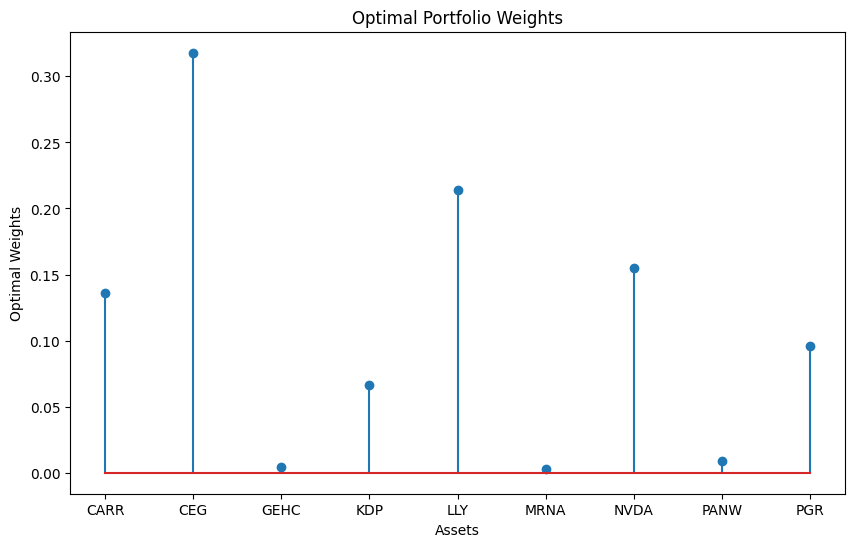

In [ ]:
plt.figure(figsize=(10, 6))
plt.stem(df_optimize['Actions'], df_optimize['Poids'])

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [ ]:
assets = df_optimize['Actions'].tolist()
weights = df_optimize['Poids'].tolist()
weights = np.array(weights)

asset_prices = yf.download(assets, start_date, end_date)['Adj Close']
asset_prices = asset_prices.dropna()
print(asset_prices)

# asset_returns = Rendements des actifs du PF
asset_returns = Calcul_Rendement(asset_prices)
print(asset_returns)

# PF_prices = Prix du PF
PF_prices = Calcul_Valeur_PF(asset_prices, weights)
print(PF_prices)

#PF_returns = Rendement du PF
PF_returns = Calcul_Rendement(PF_prices)
print(PF_returns)

[*********************100%%**********************]  9 of 9 completed
                 CARR         CEG       GEHC        KDP         LLY  \
Date                                                                  
2022-12-15  41.614315   88.620560  59.904148  35.504650  356.493683   
2022-12-16  40.918449   87.138611  56.649361  34.961861  356.355072   
2022-12-19  40.673431   86.674271  56.409744  35.204182  354.285492   
2022-12-20  40.546017   86.506317  57.118599  35.146015  356.127319   
2022-12-21  41.436977   88.571159  56.869003  35.407726  364.415619   
...               ...         ...        ...        ...         ...   
2024-01-17  55.060001  111.919998  72.750000  31.740000  628.909973   
2024-01-18  55.400002  111.410004  73.519997  31.799999  623.349976   
2024-01-19  55.880001  114.449997  74.110001  31.889999  628.580017   
2024-01-22  56.320000  117.209999  74.639999  31.500000  630.880005   
2024-01-23  55.910000  118.690002  73.669998  31.740000  629.679993   

       

Indice

In [ ]:
date_debut = asset_prices.index[0]
Indices_prices = yf.download("^GSPC", start=date_debut, end=end_date)['Adj Close']
Indices_prices = Indices_prices.to_frame()
Indices_prices = Indices_prices.rename(columns={'Adj Close': 'Indice'})
print(Indices_prices)

Indices_returns = Calcul_Rendement(Indices_prices)
print(Indices_returns)

[*********************100%%**********************]  1 of 1 completed
                 Indice
Date                   
2022-12-15  3895.750000
2022-12-16  3852.360107
2022-12-19  3817.659912
2022-12-20  3821.620117
2022-12-21  3878.439941
...                 ...
2024-01-17  4739.209961
2024-01-18  4780.939941
2024-01-19  4839.810059
2024-01-22  4850.430176
2024-01-23  4864.600098

[276 rows x 1 columns]
              Indice
Date                
2022-12-16 -0.011138
2022-12-19 -0.009008
2022-12-20  0.001037
2022-12-21  0.014868
2022-12-22 -0.014452
...              ...
2024-01-17 -0.005617
2024-01-18  0.008805
2024-01-19  0.012314
2024-01-22  0.002194
2024-01-23  0.002921

[275 rows x 1 columns]


Taux sans risque

In [ ]:
#Calcul Rf
fred = fredapi.Fred(api_key='55cc7affbaba092c1f14f4fd882eaaf5')
us_treasury_10y = fred.get_series_latest_release('GS10') / 100
rfr = us_treasury_10y.iloc[-1]
print(rfr* 100, '%')

4.02 %


Analyse du risque et du rendement

Rendement moyen

In [ ]:
PF_returns_mean = Calcul_mean (PF_returns)
Indices_returns_mean = Calcul_mean (Indices_returns)

0.2469157 %
0.0841968 %


C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(mean)


CAGR

In [ ]:
PF_prices_CAGR = Calcul_CAGR(PF_prices)
Indices_prices_CAGR = Calcul_CAGR(Indices_prices)


82.37375385996579 %
22.571310740013082 %


C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  CAGR = float(CAGR)
C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  CAGR = float(CAGR)


Matrice covariance

In [ ]:
PF_std = Calcul_Std_PF(asset_returns, weights)
Indices_std = Indices_returns.std()
Indices_std = float(Indices_std)
print (Indices_std)

0.17298380666247365
0.00826642428638325


C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1816209147.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Indices_std = float(Indices_std)


SHARPE RATIO PF

In [ ]:
PF_sharpe_ratio = Calcul_Sharpe_Ratio(PF_prices_CAGR, rfr, PF_std)
Indices_sharpe_ratio = Calcul_Sharpe_Ratio(Indices_prices_CAGR, rfr, Indices_std)

4.529542699499601
22.441759698412127


Mesures alternative du risques

In [ ]:
PF_sortino_ratio = Calcul_Sortino_Ratio (PF_returns, rfr)
Indices_sortino_ratio = Calcul_Sortino_Ratio (Indices_returns, rfr)

Expected return  :  0.24691565980261085 %
Downside risk  :  0.7013728863727192 %
Sortino ratio :  -5.379569717487367
Expected return  :  0.08419682795018262 %
Downside risk  :  0.4942771105245756 %
Sortino ratio :  -7.962746176679626


-0.09012032881140308


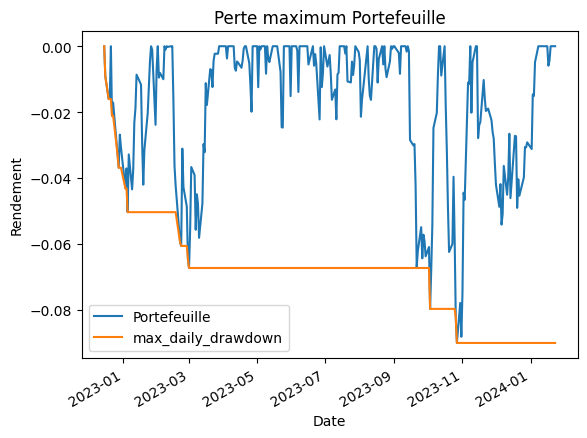

-0.10276617093291363


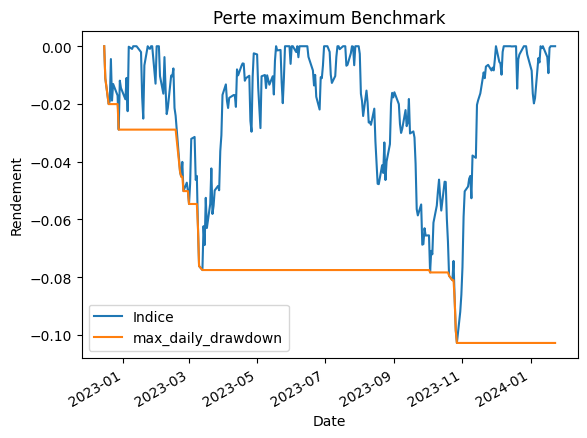

-0.09012032881140308


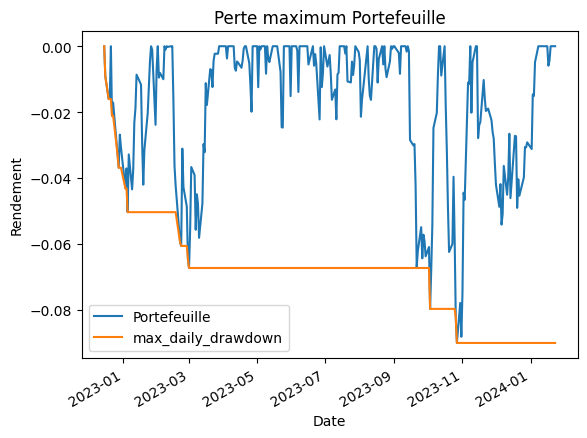

-0.10276617093291363


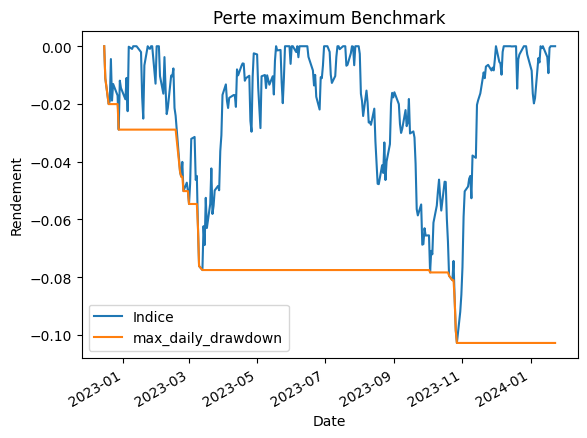

In [ ]:
PF_Perte_Maximum = Calcul_DrawDown (PF_prices, 'Perte maximum Portefeuille')[0]
Indices_Perte_Maximum = Calcul_DrawDown (Indices_prices, 'Perte maximum Benchmark')[0]
Save_Graphique_PF_Perte_Maximum =  Calcul_DrawDown (PF_prices, 'Perte maximum Portefeuille')[1]
Save_Graphique_Indices_Perte_Maximum = Calcul_DrawDown (Indices_prices, 'Perte maximum Benchmark')[1]

C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VaR95 = float(VaR95)
C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  CVaR95 = float(CVaR95)


VaR 95 : -0.017954315571166158
CVaR 95 : -0.022092271926572964


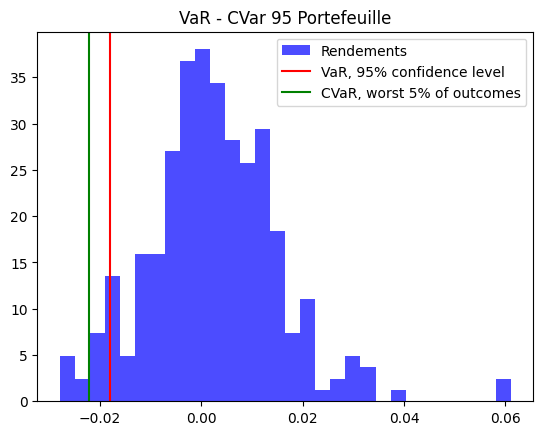

C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VaR95 = float(VaR95)
C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1817730087.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  CVaR95 = float(CVaR95)


VaR 95 : -0.013757472618720856
CVaR 95 : -0.015598691206240347


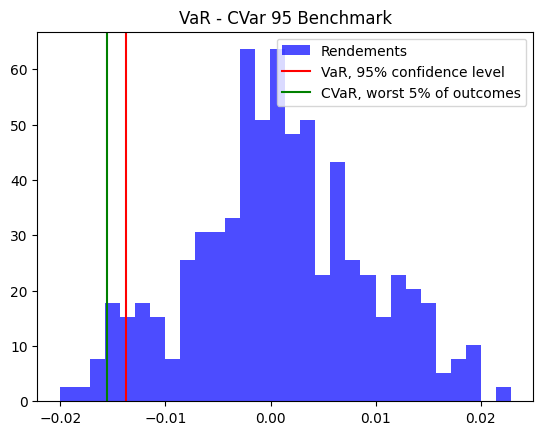

In [ ]:
PF_VaR_95 = Calcul_VaR_95 (PF_returns)
PF_CVar_95 = Calcul_CVaR_95 (PF_returns, PF_VaR_95)
Save_Graphique_PF_VaR_CVaR_95 = Creation_Graphique_VaR_CVaR_95 (PF_returns, PF_VaR_95, PF_CVar_95, 'VaR - CVar 95 Portefeuille', enregistrement_graphiques)
Indices_VaR_95 = Calcul_VaR_95 (Indices_returns)
Indices_CVar_95 = Calcul_CVaR_95 (Indices_returns, Indices_VaR_95)
Save_Graphique_Indices_VaR_CVaR_95 = Creation_Graphique_VaR_CVaR_95 (Indices_returns, Indices_VaR_95, Indices_CVar_95, 'VaR - CVar 95 Benchmark', enregistrement_graphiques)

Portefeuille base 100

In [ ]:
Base_100 = Creation_DF_Base100 (PF_prices, PF_returns, Indices_returns)

C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1280523428.py:16: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  Base_100['Portefeuille'][0] = 100
C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1280523428.py:17: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  Base_100['Indice'][0] = 100
C:\Users\Mon Port\AppData\Local\Temp\ipykernel_29768\1280523428.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Base_100['Por

           Portefeuille      Indice
Date                               
2022-12-15          100         100
2022-12-16    99.305028   99.099248
2022-12-19    99.366011   99.202048
2022-12-20   101.610741  100.676983
2022-12-21    99.461554    99.22203
...                 ...         ...
2024-01-17   189.069419  124.104181
2024-01-18   192.954823  125.632338
2024-01-19   194.103503  125.908016
2024-01-22   194.437523   126.27584
2024-01-23          NaN         NaN

[276 rows x 2 columns]


Evolution du cours du Portfeuille et de ses composants

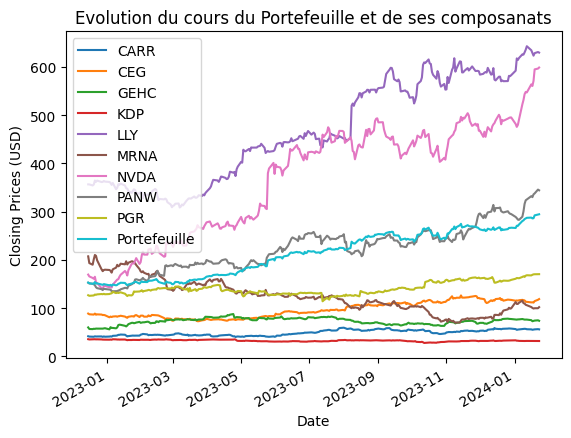

In [ ]:
Save_Graphique_Cours_PF = Processus_Creation_Sauvegarde_Graphique_2df (asset_prices, "Closing Prices (USD)", PF_prices, 'Portefeuille', 'Evolution du cours du Portefeuille et de ses composanats', enregistrement_graphiques)

Rendements Portefuille vs Benchmark

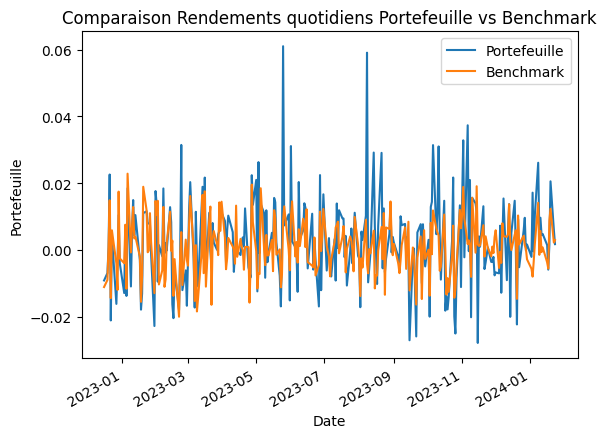

In [ ]:
Save_Graphique_Rendements_PF_vs_Benchmark = Processus_Creation_Sauvegarde_Graphique_2df (PF_returns, 'Portefeuille', Indices_returns, 'Benchmark', 'Comparaison Rendements quotidiens Portefeuille vs Benchmark', enregistrement_graphiques)

Rendement cumulé

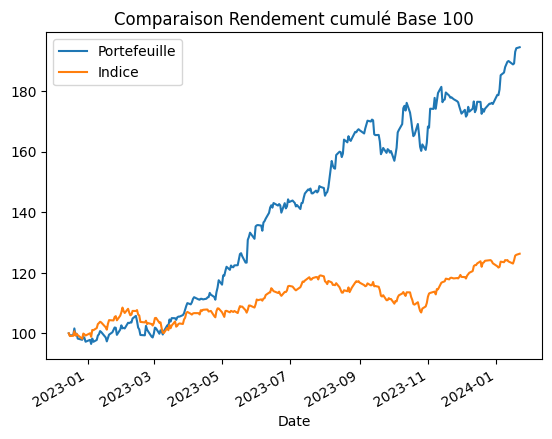

In [ ]:
Save_Graphique_Base100 = Processus_Creation_Sauvegarde_Graphique_1df (Base_100, 'Comparaison Rendement cumulé Base 100', enregistrement_graphiques)

Créer un tableau recapitulatif

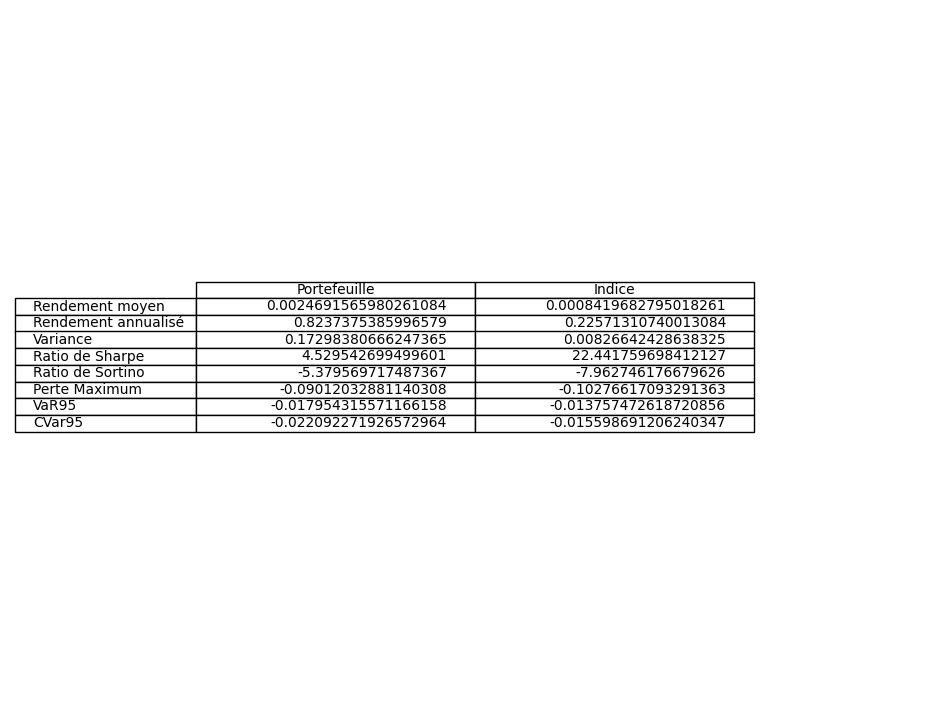

In [ ]:
Mesure_Valeurs = ['Rendement moyen', 'Rendement annualisé', 'Variance', 'Ratio de Sharpe', 'Ratio de Sortino', 'Perte Maximum', 'VaR95', 'CVar95']
Portefeuille_Valeurs = [PF_returns_mean, PF_prices_CAGR, PF_std, PF_sharpe_ratio, PF_sortino_ratio, PF_Perte_Maximum, PF_VaR_95, PF_CVar_95]
Indices_Valeurs = [Indices_returns_mean, Indices_prices_CAGR, Indices_std, Indices_sharpe_ratio, Indices_sortino_ratio, Indices_Perte_Maximum, Indices_VaR_95, Indices_CVar_95]

Tableau_final = pd.DataFrame(columns=['Mesure','Portefeuille', 'Indice'], index=range(8))
Tableau_final = Tableau_final.assign(Mesure = Mesure_Valeurs, Portefeuille = Portefeuille_Valeurs, Indice=Indices_Valeurs)
Tableau_final = Tableau_final.set_index("Mesure")

# Créer une figure Matplotlib
fig, ax = plt.subplots(figsize=(12, 9))

# Afficher le tableau dans la figure
tbl = table(ax, Tableau_final, loc='center', colWidths=[0.3]*len(Tableau_final.columns))

# Masquer les axes
ax.axis('off')

# Enregistrer l'image du tableau à l'adresse spécifiée
Save_Tableau = r'C:\Users\Mon Port\OneDrive\Documents\COURS M2\S1\UE1\Modélisation Financière\Graphiques rapport\tab_image.png'
plt.savefig(Save_Tableau, bbox_inches='tight', pad_inches=0.05)

Générer le rapport PDF

In [ ]:
# Création du fichier PDF
pdf_filename
c = canvas.Canvas(pdf_filename, pagesize=letter)

# Ajout du titre
c.setFont("Helvetica", 14)
c.drawString(72, 500, "Rapport avec Graphique")

# Ajout du graphique depuis l'image sauvegardée
c.drawInlineImage(Save_Tableau, 72, 400, width=400, height=300)
c.drawInlineImage(Save_Graphique_Cours_PF, 72, 100, width=400, height=300)

#Page 2
nouvelle_page_PDF_2_graphiques (Save_Graphique_Rendements_PF_vs_Benchmark, Save_Graphique_Base100)

#Page 3
nouvelle_page_PDF_2_graphiques (Save_Graphique_PF_Perte_Maximum, Save_Graphique_Indices_Perte_Maximum)

#Page 4
nouvelle_page_PDF_2_graphiques (Save_Graphique_PF_VaR_CVaR_95, Save_Graphique_Indices_VaR_CVaR_95)

# Sauvegarde du PDF
c.save()
print(f"Le rapport a été généré avec succès : {pdf_filename}")


Le rapport a été généré avec succès : C:\Users\Mon Port\OneDrive\Documents\rapport.pdf


Calcul Active Return

In [ ]:
active_return = PF_returns_mean.values - Indices_returns_mean.values
active_return = float(active_return[0])
print(active_return*100, '%')

AttributeError: 'float' object has no attribute 'values'